## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [280]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt

def calibrate():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        img_size = img.shape[1],img.shape[0] 
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            """
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)
            """
    #cv2.destroyAllWindows()
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx, dist

mtx, dist = calibrate()

True

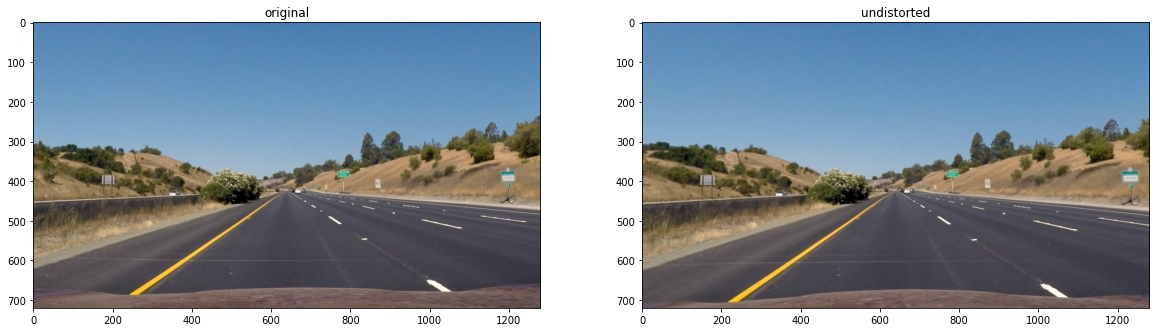

In [501]:
# Test undistortion on an image
img = cv2.imread('test_images/straight_lines1.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.undistort(rgb, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(rgb)
ax1.set_title("original")
ax2.imshow(dst)
ax2.set_title("undistorted")
cv2.imwrite("calibration2_calibrated.jpg", dst)

## Use color transforms, gradients, etc., to create a thresholded binary image.


In [502]:
def abs_sobel_thresh(gray, orient='x', thres=(0,255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thres[0]) & (scaled_sobel <= thres[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return sxbinary

def get_mag_thresh(gray, sobel_kernel=3, thres=(0, 255)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    bm = np.zeros_like(scaled)
    bm[(scaled >= thres[0]) & (scaled <= thres[1])] = 1
    # 6) Return this mask as your binary_output image
    return bm

def get_dir_threshold(gray, sobel_kernel=3, thres=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(sobely,sobelx)
    # 5) Create a binary mask where direction thresholds are met
    bm = np.zeros_like(direction)
    bm[(direction >= thres[0]) & (direction <= thres[1])] = 1
    # 6) Return this mask as your binary_output image
    return bm

def binary_grads(img, debug=False):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    m_sobel_kernel = 10
    m_thres = (5,200)
    d_sobel_kernel = 15
    d_thres = (0.7, 1.3)
    mag={
        "d": get_dir_threshold(hls[:,:,2], d_sobel_kernel, d_thres),
        "m": get_mag_thresh(hls[:,:,2], m_sobel_kernel, m_thres),
        "gx": abs_sobel_thresh(hls[:,:,2], orient='x', thres=(3, 255)),
        "gy": abs_sobel_thresh(hls[:,:,2], orient='y', thres=(3, 255)),
    }
    mag["combined"] = np.zeros_like(mag["d"])
    mag["combined"][
        (mag["d"] == 1) & (mag['m'] == 1) 
        | (mag["gx"] == 1) & (mag['gy'] == 1) 
    ] = 1

    if debug:
        f, axes = plt.subplots(3, 2, figsize=(20,10))
        axes = [item for sublist in axes for item in sublist]
        axid = 0
        for title in mag:
            axes[axid].imshow(mag[title], cmap="gray")
            axes[axid].set_title(title)
            axid += 1

    return mag["combined"]



In [503]:
## Apply a perspective transform to rectify binary image ("birds-eye view").

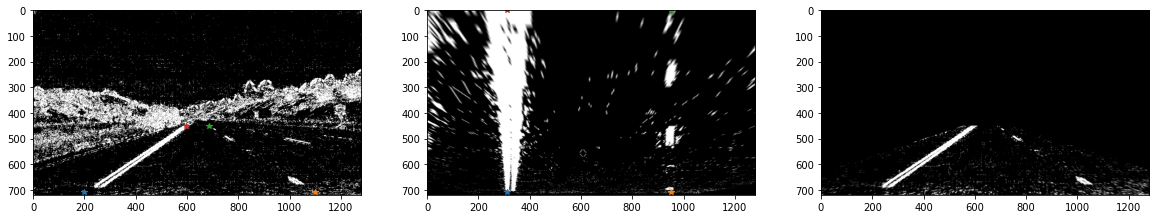

In [506]:
src_ords = np.float32([
    [200,710],
    [1100,710],
    [685,450],
    [595,450],
])
dst_ords = np.float32([
    [310, 710+ha],
    [950,710+ha],
    [950,ha],
    [310,ha],
])

def get_bird_eye(img):
    Perspective_M = cv2.getPerspectiveTransform(src_ords,dst_ords)
    return cv2.warpPerspective(img, Perspective_M, dsize=(img.shape[1],img.shape[0]))

def bird2normal(img):
    Perspective_M = cv2.getPerspectiveTransform(dst_ords, src_ords)
    return cv2.warpPerspective(img, Perspective_M, dsize=(img.shape[1],img.shape[0]))
    
    
f, axes = plt.subplots(1, 3, figsize=(20,10))

bm = binary_grads(img)
cv2.imwrite("thresholded.jpg", bm)
axes[0].imshow(bm, cmap='gray')
for x,y in src_ords:
    axes[0].plot(x,y,"*")

birdeye = get_bird_eye(bm)
axes[1].imshow(birdeye, cmap='gray')
for x,y in dst_ords:
    axes[1].plot(x,y,"*")
cv2.imwrite('birdeye.jpg', birdeye)

normal = bird2normal(birdeye)
axes[2].imshow(normal, cmap='gray')

In [507]:
## Detect lane pixels and fit to find the lane boundary.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

True

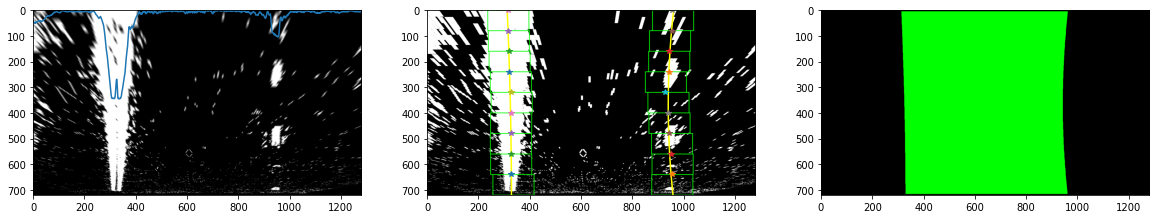

In [510]:
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))

def find_lane_pixels(bird, debug=False):
    histogram = np.sum(bird[bird.shape[0]//2:,:], axis=0)
    if debug: ax1.plot(histogram)
    # !!!
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(bird.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = bird.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    y_current = bird.shape[0]
    out_img = np.dstack((bird, bird, bird))*255
    
    lane_centers = []
    for window in range(nwindows):
        binary_warped = bird
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        if debug: ax2.imshow(out_img,)

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        lane_centers.append((leftx_current, win_y_low))
        lane_centers.append((rightx_current, win_y_low))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, lane_centers

def fit_polynomial(bird, debug=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, lane_centers = find_lane_pixels(bird,debug)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, bird.shape[0]-1, bird.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if debug: ax2.plot(left_fitx, ploty, color='yellow')
    if debug: ax2.plot(right_fitx, ploty, color='yellow')
    
    # Calculation of R_curve (radius of curvature)
    y_eval = bird.shape[0]
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    if debug: 
        for x,y in lane_centers:
            ax2.plot(x,y,"*")
    
    lane_img = np.zeros_like(out_img)
    for y in range(15,bird.shape[0], 10):
        bl = int(left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]), y
        tr = int(right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]), y - 10
        lane_img = cv2.rectangle(lane_img, bl, tr, (0,255,0), -1)

    return out_img, lane_img, left_curverad,right_curverad,left_fit,right_fit


bird = get_bird_eye(bm)
ax1.imshow(bird,cmap='gray')

out_img,lane_img,left_curverad,right_curverad,left_fit,right_fit = fit_polynomial(bird, debug=True)
ax3.imshow(lane_img)

cv2.imwrite("pixels_found.jpg",out_img)

In [490]:
## Determine the curvature of the lane and vehicle position with respect to center.

def distance2center(bird):
    histogram = np.sum(bird[bird.shape[0]//2:,:], axis=0)

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print(leftx_base,midpoint,rightx_base)
    return (rightx_base + leftx_base)/2 - midpoint


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


340 640 947


True

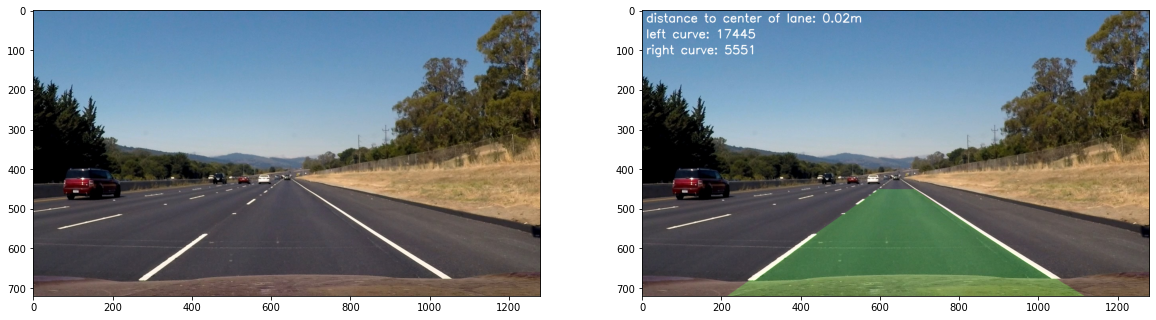

In [511]:
## Warp the detected lane boundaries back onto the original image.
## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def process_image(img):
    #rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.undistort(rgb, mtx, dist, None, mtx)

    bm = binary_grads(dst)

    bird = get_bird_eye(bm)
    bird_img,lane_img,left_curverad,right_curverad,left_fit,right_fit = fit_polynomial(bird)
    lane_ahead = bird2normal(lane_img)
    center_distance = distance2center(bird) * 3.7 / 700

    final = np.int32(img + lane_ahead*0.2)
    texts = [
        f"distance to center of lane: %.2fm" % center_distance,
        f"left curve: {int(left_curverad)}",
        f"right curve: {int(right_curverad)}",
    ]
    font = cv2.FONT_HERSHEY_SIMPLEX
    height = 30
    for t in texts:
        cv2.putText(final,t, (10, height), font, 1.0, (255,255,255),2,cv2.LINE_AA)
        height += 40

    return final

import matplotlib.image as mpimg
img = mpimg.imread('test_images/straight_lines2.jpg')
final = process_image(img)

f, (ax1,ax2,) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax2.imshow(final)
cv2.imwrite("final.jpg", final)



In [493]:
import os
#f, axes = plt.subplots(8, 2, figsize=(20,100))
i = 0
for f in os.listdir("test_images/"):
    img = mpimg.imread("test_images/"+f)
    new = process_image(img)
    #axes[i][0].imshow(img)
    #axes[i][1].imshow(new)
    i += 1

    cv2.imwrite('test_images_output/'+f, new)


324 640 953
324 640 953
324 640 953
324 640 953
324 640 953
324 640 953
324 640 953
324 640 953


In [494]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]

324 640 953
Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



t:   8%|▊         | 2/25 [00:00<00:03,  7.41it/s, now=None]

324 640 953


t:  12%|█▏        | 3/25 [00:00<00:04,  5.21it/s, now=None]

324 640 953


t:  16%|█▌        | 4/25 [00:00<00:04,  4.61it/s, now=None]

324 640 953


t:  20%|██        | 5/25 [00:01<00:04,  4.61it/s, now=None]

324 640 953


t:  24%|██▍       | 6/25 [00:01<00:04,  4.60it/s, now=None]

324 640 953


t:  28%|██▊       | 7/25 [00:01<00:03,  4.57it/s, now=None]

324 640 953


t:  32%|███▏      | 8/25 [00:01<00:03,  4.57it/s, now=None]

324 640 953


t:  36%|███▌      | 9/25 [00:01<00:03,  4.58it/s, now=None]

324 640 953


t:  40%|████      | 10/25 [00:02<00:03,  4.60it/s, now=None]

324 640 953


t:  44%|████▍     | 11/25 [00:02<00:03,  4.61it/s, now=None]

324 640 953


t:  48%|████▊     | 12/25 [00:02<00:02,  4.60it/s, now=None]

324 640 953


t:  52%|█████▏    | 13/25 [00:02<00:02,  4.69it/s, now=None]

324 640 953


t:  56%|█████▌    | 14/25 [00:02<00:02,  4.71it/s, now=None]

324 640 953


t:  60%|██████    | 15/25 [00:03<00:02,  4.69it/s, now=None]

324 640 953


t:  64%|██████▍   | 16/25 [00:03<00:01,  4.78it/s, now=None]

324 640 953


t:  68%|██████▊   | 17/25 [00:03<00:01,  4.72it/s, now=None]

324 640 953


t:  72%|███████▏  | 18/25 [00:03<00:01,  4.38it/s, now=None]

324 640 953


t:  76%|███████▌  | 19/25 [00:04<00:01,  4.08it/s, now=None]

324 640 953


t:  80%|████████  | 20/25 [00:04<00:01,  4.04it/s, now=None]

324 640 953


t:  84%|████████▍ | 21/25 [00:04<00:01,  3.81it/s, now=None]

324 640 953


t:  88%|████████▊ | 22/25 [00:04<00:00,  3.79it/s, now=None]

324 640 953


t:  92%|█████████▏| 23/25 [00:05<00:00,  3.81it/s, now=None]

324 640 953


t:  96%|█████████▌| 24/25 [00:05<00:00,  3.64it/s, now=None]

324 640 953


t: 100%|██████████| 25/25 [00:05<00:00,  3.79it/s, now=None]

324 640 953


324 640 953


Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 10.8 s, sys: 2.4 s, total: 13.2 s
Wall time: 6.55 s


In [495]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))